# STAT186: partisanship

In [1548]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from copy import deepcopy
%matplotlib inline
import seaborn as sns

In [1395]:
def preprocess_PCI(PCI):
    p = deepcopy(PCI)
    p = p[(p['Year'] > 1994) & (p['Year'] < 2000)]
    p['Month'] = [i % 12 + 1 for i in range(len(p))]
    return p

def daily_freq(PCI, order = 2):
    PCI['date'] = '15/' + PCI['Month'].astype(str) + '/' + PCI['Year'].astype(str)
    PCI['date'] = pd.to_datetime(PCI['date'], format = '%d/%m/%Y', errors = 'coerce')
    PCI = PCI.drop(['Year', 'Month'], axis = 1).set_index('date')
    return PCI.resample('D').interpolate(method='spline', order=order)

def normalize(x):
    return (x - x.mean())/x.std()

def date_format(d):
    d[['decs_day', 'decs_mo', 'decs_yr']] = d[['decs_day', 'decs_mo', 'decs_yr']].fillna(0)
    d['date'] = d['decs_day'].astype(int).astype(str) + '/' + d['decs_mo'].astype(int).astype(str) + '/' + d['decs_yr'].astype(int).astype(str)
    d['date'] = pd.to_datetime(d['date'], format = '%d/%m/%Y', errors = 'coerce')
    d.drop(['decs_day', 'decs_mo', 'decs_yr'], axis = 1, inplace = True)
    return d

def subtract_first_judge(df):
    df = df.set_index(['masterid', 'date'])
    fj = df[df['judgeopinion']==1.0].drop(['Partisan Conflict', 'judgeopinion'], axis = 1)
    fj['Partisan Conflict'] = 0
    fj['judgeopinion'] = 0
    nfj = df[df['judgeopinion']!=1.0]
    return nfj.subtract(fj)
    

In [1393]:
os.listdir('../data/')

['.DS_Store',
 'crime_cat.csv',
 'pci-index-release.xlsx',
 'stat186-projdata-2.csv',
 'states-codes-capitals.csv',
 'states-codes-supcourt-city.csv',
 'weather']

In [1488]:
data = pd.read_csv('../data/stat186-projdata-2.csv', index_col = 0, low_memory=False)
data = date_format(data)

In [1489]:
data.shape

(171409, 339)

In [1490]:
data.head(2)

,masterid,id_1,coder,coderid,casen_1,juris,first_ct,agency,agency_r,arbitrat,...,race,gender,pajid,jpid,agedec,EWI,select,retentn,cj,date
0,95.010009765625,102,TEB,1130,1.0,2.0,1.0,0.0,88.0,0.0,...,1.0,1.0,47.23,1.0,66.0,-1.454818,5.0,5.0,0.0,1995-12-01
1,95.01001739501953,103,TEB,1130,2.0,2.0,2.0,0.0,88.0,0.0,...,1.0,1.0,26.20,1.0,65.0,-1.454818,5.0,5.0,0.0,1995-12-01


In [1491]:
judge_vars=['judgecode', 'brthyr','race', 'gender','pajid','jpid', 'agedec', 'EWI', 'select', 'retentn', 'cj']

In [1492]:
PCI = pd.read_excel('../data/pci-index-release.xlsx')
PCI = preprocess_PCI(PCI)
#PCI_lin = daily_freq(PCI, order = 1)
PCI = daily_freq(PCI, order = 3)
PCI = normalize(PCI)
PCI.head()

,Partisan Conflict
date,
1995-01-15,0.253971
1995-01-16,0.338251
1995-01-17,0.419971
1995-01-18,0.497339
1995-01-19,0.570447


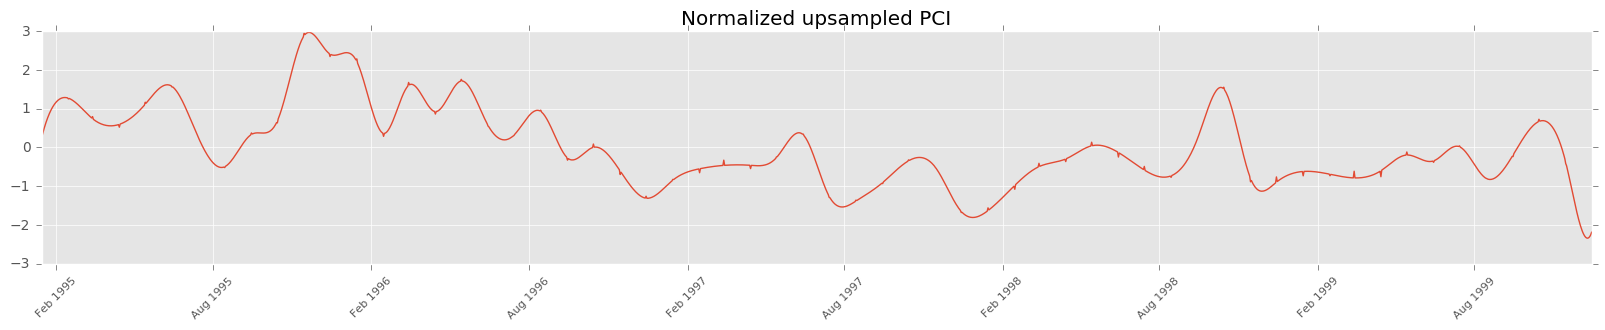

In [1501]:
fig, ax = plt.subplots(figsize = (20, 3))
ax.set_title('Normalized upsampled PCI')
plt.xticks(rotation=45, fontsize = 8)
#ax.plot(PCI_lin, label = 'PCI')
ax.plot(PCI, label = 'PCI')

In [1493]:
data = pd.merge(data, PCI.reset_index(), on = ['date'])

## Simple descriptive stats for the report 

In [1464]:
m=data[judge_vars].groupby('judgecode').mean()

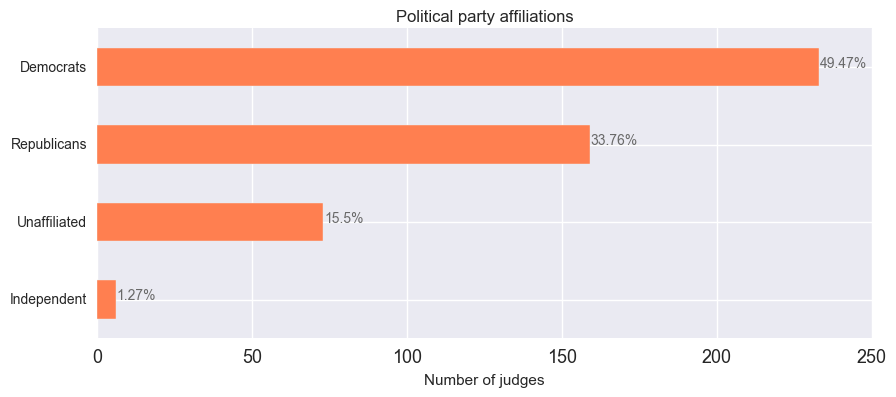

In [1580]:
ax = m['jpid'].fillna(0).value_counts().plot(kind='barh', figsize=(10,4),
                                        color="coral", fontsize=13);

dt = {'Democrats': np.sum(m['jpid'] == 1), 
      'Republicans': np.sum(m['jpid'] == 2), 
      'Independent': np.sum(m['jpid'] == 3), 
      'Unaffiliated': np.sum(m['jpid'].isna())}
totals = []
for i in ax.patches:
    totals.append(i.get_width())  
# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.25, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=10,
            color='dimgrey')
sorted_dt = sorted(dt.items(), key=lambda kv: kv[1], reverse = True)
ax.set_yticklabels([sorted_dt[i][0] for i in range(len(sorted_dt))], fontsize = 10)
ax.set_title('Political party affiliations', size = 12)
ax.set_xlabel('Number of judges')
ax.invert_yaxis()

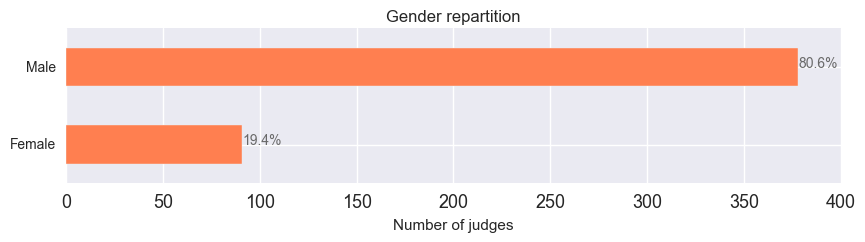

In [1581]:
ax = m['gender'].dropna().value_counts().plot(kind='barh', figsize=(10,2),
                                        color="coral", fontsize=13);

dt = {'Male': np.sum(m['jpid'] == 1), 
      'Female': np.sum(m['jpid'] == 2)}
totals = []
for i in ax.patches:
    totals.append(i.get_width())  
# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.25, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=10,
            color='dimgrey')
    
sorted_dt = sorted(dt.items(), key=lambda kv: kv[1], reverse = True)
ax.set_yticklabels([sorted_dt[i][0] for i in range(len(sorted_dt))], fontsize = 10)
ax.set_title('Gender repartition', size = 12)
ax.set_xlabel('Number of judges')
ax.invert_yaxis()

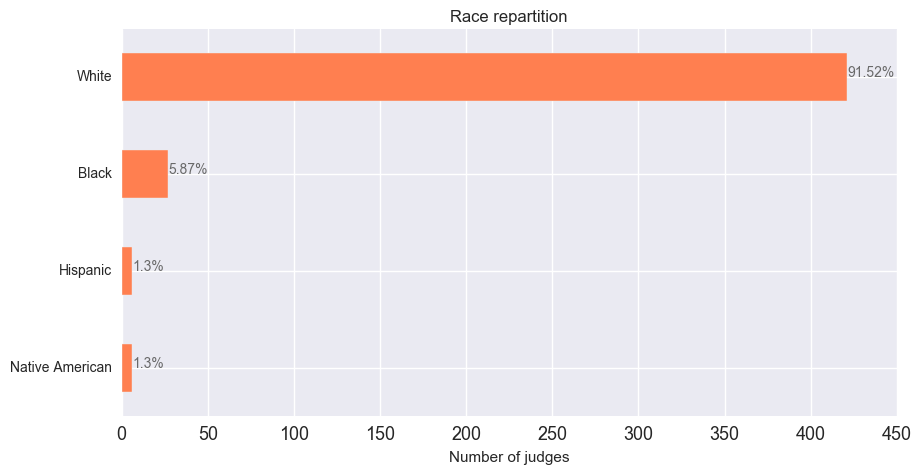

In [1582]:
ax = m['race'].dropna().value_counts().plot(kind='barh', figsize=(10,5),
                                        color="coral", fontsize=13);

dt = {'White': np.sum(m['jpid'] == 1), 
      'Black': np.sum(m['jpid'] == 2),
      'Hispanic': np.sum(m['jpid'] == 3),
      'Hispanic': np.sum(m['jpid'] == 4),
      'Native American': np.sum(m['jpid'] == 5),
     }

totals = []
for i in ax.patches:
    totals.append(i.get_width())  
# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.25, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=10,
            color='dimgrey')
    
sorted_dt = sorted(dt.items(), key=lambda kv: kv[1], reverse = True)
ax.set_yticklabels([sorted_dt[i][0] for i in range(len(sorted_dt))], fontsize = 10)
ax.set_title('Race repartition', size = 12)
ax.set_xlabel('Number of judges')
ax.invert_yaxis()

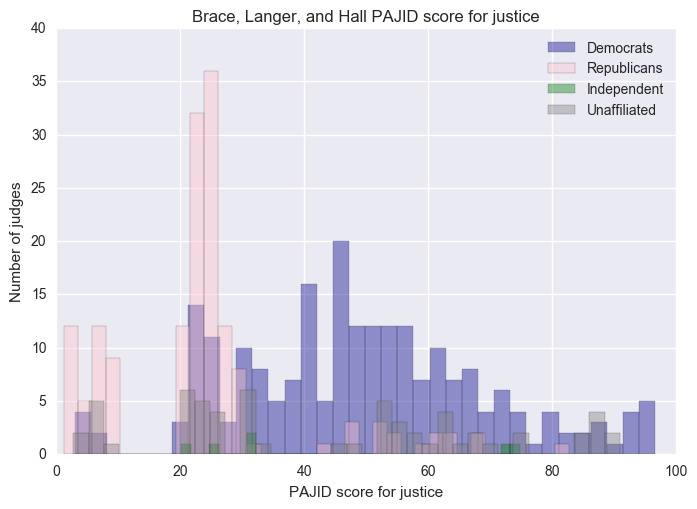

In [1577]:
f, ax = plt.subplots(1, 1)

sns.distplot(m[m['jpid']==1]['pajid'].dropna(), hist=True, kde=False, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             label = 'Democrats')

sns.distplot(m[m['jpid']==2]['pajid'].dropna(), hist=True, kde=False, 
             bins=int(180/5), color = 'pink', 
             hist_kws={'edgecolor':'black'},
             label = 'Republicans')

sns.distplot(m[m['jpid']==3]['pajid'].dropna(), hist=True, kde=False, 
             bins=int(180/5), color = 'green', 
             hist_kws={'edgecolor':'black'},
             label = 'Independent')

sns.distplot(m[m['jpid'].isna()]['pajid'].dropna(), hist=True, kde=False, 
             bins=int(180/5), color = 'grey', 
             hist_kws={'edgecolor':'black'},
             label = 'Unaffiliated')
ax.set_xlabel('PAJID score for justice')
ax.set_ylabel('Number of judges')
ax.legend()
ax.set_title('Brace, Langer, and Hall PAJID score for justice')

In [1596]:
c=data[['judgeopinion']].groupby('masterid').apply(lambda x : x['judgeopinion'].nunique())

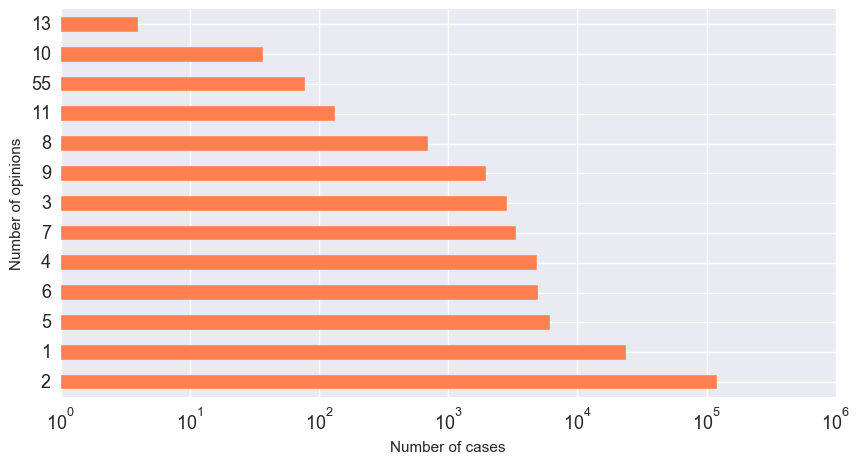

In [1601]:
ax = data['judgeopinion'].value_counts().plot(kind='barh', figsize=(10,5),color="coral", fontsize=13, log = True)
ax.set_ylabel('Number of opinions')
ax.set_xlabel('Number of cases')

# Control for observable confounders and lagged outcomes

In [1241]:
data.head(2)

,masterid,id_1,coder,coderid,casen_1,juris,first_ct,agency,agency_r,arbitrat,...,gender,pajid,jpid,agedec,EWI,select,retentn,cj,date,Partisan Conflict
0,95.010009765625,102,TEB,1130,1.0,2.0,1.0,0.0,88.0,0.0,...,1.0,47.23,1.0,66.0,-1.454818,5.0,5.0,0.0,1995-12-01,2.556076
1,95.01001739501953,103,TEB,1130,2.0,2.0,2.0,0.0,88.0,0.0,...,1.0,26.20,1.0,65.0,-1.454818,5.0,5.0,0.0,1995-12-01,2.556076


In [1242]:
case_data = data[['date', 'masterid', 'judgecode', 
                  'pajid', 'jpid', 'judgeopinion', 
                  'race', 'gender', 'agedec', 
                  'Partisan Conflict']]

In [1243]:
case_data.head(2)

,date,masterid,judgecode,pajid,jpid,judgeopinion,race,gender,agedec,Partisan Conflict
0,1995-12-01,95.010009765625,107.0,47.23,1.0,1,1.0,1.0,66.0,2.556076
1,1995-12-01,95.01001739501953,109.0,26.20,1.0,1,1.0,1.0,65.0,2.556076


In [1244]:
case_data.shape

(168172, 10)

In [1245]:
case_data = remove_no_judge_code(case_data)
case_data = case_data[case_data['judgeopinion'] != 55]

In [1246]:
case_data.head()

,date,masterid,pajid,jpid,judgeopinion,race,gender,agedec,Partisan Conflict
0,1995-12-01,95.010009765625,47.23,1.0,1,1.0,1.0,66.0,2.556076
1,1995-12-01,95.01001739501953,26.20,1.0,1,1.0,1.0,65.0,2.556076
2,1995-12-01,95.01006317138672,47.23,1.0,1,1.0,1.0,66.0,2.556076
3,1995-12-01,95.01007080078125,30.69,1.0,1,1.0,1.0,58.0,2.556076
4,1995-12-01,95.01068115234375,46.88,1.0,1,2.0,1.0,51.0,2.556076


In [1247]:
c = subtract_first_judge(case_data)

In [1248]:
c = c.dropna(how = 'all', axis = 0)

In [1251]:
def features_same_party(cd):
    dat = cd.copy()
    dat = dat[dat['jpid']==0]
    
    dat['dissent'] = dat['judgeopinion'].map({1:0, 2:0, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1})
    
    dat['pajid'] = normalize(dat['pajid'])
    dat['agedec'] = normalize(dat['agedec'])
    dat['race'] = (dat['race'] != 0) * 1
    dat['gender'] = (dat['gender'] != 0) * 1

    dat = dat.fillna(0)
    
    y = dat['dissent'] * 1
    x = dat[['Partisan Conflict', 'pajid', 'agedec', 'race', 'gender']] #.drop(['dissent', 'judgeopinion', 'jpid'], axis = 1)
    return y, x

def features_different_party(cd):
    dat = cd.copy()
    dat['dissent'] = dat['judgeopinion'].map({1:0, 2:0, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1})
    dat = dat[dat['jpid']!=0]
    
    dat['pajid'] = normalize(dat['pajid'])
    dat['agedec'] = normalize(dat['agedec'])
    dat['race'] = (dat['race'] != 0) * 1
    dat['gender'] = (dat['gender'] != 0) * 1

    dat = dat.fillna(0)
    #dat = dat.dropna()
    
    y = dat['dissent'] * 1
    x = dat[['Partisan Conflict', 'pajid', 'agedec', 'race', 'gender']] #.drop(['dissent', 'judgeopinion', 'jpid'], axis = 1)
    return y, x

In [1252]:
yd, xd = features_different_party(c)
ys, xs = features_same_party(c)

In [1065]:
dissent_rate_different = yd.groupby('date').apply(lambda x : np.sum(x)/len(x))
dissent_rate_same = ys.groupby('date').apply(lambda x : np.sum(x)/len(x))

(array([728325., 728506., 728690., 728872., 729056., 729237., 729421.,
        729602.]), <a list of 8 Text xticklabel objects>)

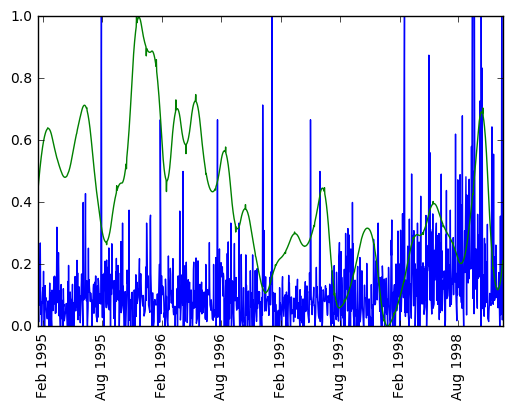

In [1066]:
plt.plot(dissent_rate_different)
#plt.plot(dissent_rate_same)
plt.plot((PCI - np.min(PCI))/ (np.max(PCI)-np.min(PCI)))
plt.xticks(rotation = 'vertical')

In [1067]:
yd.head()

masterid           date      
95.010009765625    1995-12-01    0.0
95.01001739501953  1995-12-01    0.0
95.0100326538086   1995-09-29    0.0
                   1995-09-29    0.0
                   1995-09-29    0.0
Name: dissent, dtype: float64

In [1068]:
yd = yd.reset_index()
yd['Month'] = yd['date'].dt.month
yd['Year'] = yd['date'].dt.year

In [1069]:
yd.drop(['masterid', 'date'], axis =1, inplace = True)

In [1070]:
pdd = yd.groupby(['Year', 'Month']).mean()

In [1071]:
pdd['dissent'].head()

Year  Month
1995  1        0.079507
      2        0.076521
      3        0.097168
      4        0.062467
      5        0.093672
Name: dissent, dtype: float64

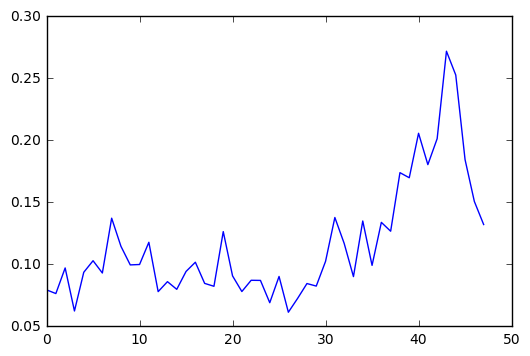

In [1072]:
plt.plot(np.array(pdd))

In [ ]:
c['opposition'] = (c['jpid']!=0)*1
c['dissent'] = (c['judgeopinion']!=2)*1

In [1040]:
c.reset_index(inplace=True)

In [1041]:
c['Month'] = c['date'].dt.month
c['Year'] = c['date'].dt.year

In [1042]:
c.head()

,masterid,date,Partisan Conflict,agedec,gender,jpid,judgeopinion,pajid,race,opposition,dissent,Month,Year
0,95.010009765625,1995-12-01,2.556076,4.0,0.0,1.0,2.0,-39.12,0.0,1,0,12,1995
1,95.010009765625,1995-12-01,2.556076,-8.0,0.0,0.0,2.0,-16.54,0.0,0,0,12,1995
2,95.010009765625,1995-12-01,2.556076,-4.0,0.0,0.0,2.0,-1.79,0.0,0,0,12,1995
3,95.010009765625,1995-12-01,2.556076,-15.0,0.0,0.0,2.0,-10.95,0.0,0,0,12,1995
4,95.01001739501953,1995-12-01,2.556076,5.0,0.0,1.0,2.0,-18.09,0.0,1,0,12,1995


In [1046]:
c.groupby(['Year', 'Month']).apply(lambda x : np.sum(x['opposition'] * x['dissent']) / np.sum(x['opposition']))

Year  Month
1995  1        0.384099
      2        0.403532
      3        0.418301
      4        0.461739
      5        0.382162
      6        0.434008
      7        0.393103
      8        0.418591
      9        0.359599
      10       0.409035
      11       0.447820
      12       0.476190
1996  1        0.354399
      2        0.468769
      3        0.407723
      4        0.405643
      5        0.412196
      6        0.387963
      7        0.403277
      8        0.358673
      9        0.350877
      10       0.455578
      11       0.416822
      12       0.468277
1997  1        0.387114
      2        0.365431
      3        0.425620
      4        0.399525
      5        0.385901
      6        0.382128
      7        0.425048
      8        0.399600
      9        0.420567
      10       0.485472
      11       0.512058
      12       0.467398
1998  1        0.422092
      2        0.485116
      3        0.473039
      4        0.491195
      5        0.575554
    

In [1254]:
import statsmodels.api as sm
xs = sm.add_constant(xs)
lr = sm.Logit(ys, xs).fit()
print(lr.params)
print(lr.bse)

Optimization terminated successfully.
         Current function value: 0.431007
         Iterations 6
const               -1.723195
Partisan Conflict   -0.113377
pajid               -0.017975
agedec               0.023339
race                 0.143211
gender              -0.008049
dtype: float64
const                0.015475
Partisan Conflict    0.012231
pajid                0.011881
agedec               0.011898
race                 0.028040
gender               0.025020
dtype: float64


## Partisanship by judge

Treatment: having a different political affiliation than the justice who writes the majority opinion.
Outcome: dissenting.

In [1426]:
# political opposition with first judge
first_judge = data[data['judgeopinion']==1]
fj = first_judge[['masterid', 'jpid', 'date']].set_index(['masterid', 'date'])
fj.columns = ['firstjpid']

In [1427]:
data2 = pd.merge(data[data['judgeopinion'] != 1], fj, 
                 left_on = ['masterid', 'date'], 
                 right_index = True, how = 'left')

In [966]:
#data2 = data2[data2['judgeopinion'] != 1]
data2['opposition'] = (data2['jpid'] != data2['firstjpid'])
data2['dissent'] = (data2['judgeopinion'] != 1) & (data2['judgeopinion'] != 2)

In [967]:
data2 = data2[['dissent', 'opposition', 'date', 'Partisan Conflict']].dropna(axis = 0)

In [968]:
data_opp = data2[data2['opposition'] == True] # keep only different political affiliations

In [969]:
data_nopp = data2[data2['opposition'] == False] # keep only SAME political affiliations

### Logistic Regression

In [971]:
y = data_opp['dissent']
x = data_opp[['Partisan Conflict']] #, 'gender', 'EWI', 'jpid', 'pajid', 'agedec', 'select', 'cj']]
x = x.fillna(0)
#x = (x - x.mean()) / x.std()

In [973]:
import statsmodels.api as sm
lr = sm.Logit(y, x).fit()
lr.params, lr.bse

Optimization terminated successfully.
         Current function value: 0.693106
         Iterations 3


(Partisan Conflict   -0.018171
 dtype: float64, Partisan Conflict    0.006675
 dtype: float64)

In [571]:
judge_vars=['judgecode', 'brthyr','race', 'gender','pajid','jpid', 'agedec', 'EWI', 'select', 'retentn', 'cj']

In [572]:
y = data_nopp['dissent']
x = data_nopp[['Partisan Conflict']] #, 'gender', 'EWI', 'jpid', 'pajid', 'agedec', 'select', 'cj']]
x = x.fillna(0)
#x = (x - x.mean()) / x.std()

In [574]:
lr = sm.Logit(y, x).fit()
lr.params, lr.bse

Optimization terminated successfully.
         Current function value: 0.692125
         Iterations 3


(Partisan Conflict   -0.092948
 dtype: float64, Partisan Conflict    0.008666
 dtype: float64)

## Dissent rate

In [1073]:
data.head()

,masterid,id_1,coder,coderid,casen_1,juris,first_ct,agency,agency_r,arbitrat,...,gender,pajid,jpid,agedec,EWI,select,retentn,cj,date,Partisan Conflict
0,95.010009765625,102,TEB,1130,1.0,2.0,1.0,0.0,88.0,0.0,...,1.0,47.23,1.0,66.0,-1.454818,5.0,5.0,0.0,1995-12-01,2.556076
1,95.01001739501953,103,TEB,1130,2.0,2.0,2.0,0.0,88.0,0.0,...,1.0,26.20,1.0,65.0,-1.454818,5.0,5.0,0.0,1995-12-01,2.556076
2,95.01006317138672,107,TEB,1130,6.0,2.0,2.0,0.0,88.0,0.0,...,1.0,47.23,1.0,66.0,-1.454818,5.0,5.0,0.0,1995-12-01,2.556076
3,95.01007080078125,108,TEB,1130,7.0,2.0,2.0,0.0,88.0,0.0,...,1.0,30.69,1.0,58.0,-1.454818,5.0,5.0,0.0,1995-12-01,2.556076
4,95.01068115234375,169,TEB,1130,68.0,2.0,2.0,0.0,88.0,0.0,...,1.0,46.88,1.0,51.0,-1.454818,5.0,5.0,0.0,1995-12-01,2.556076


In [1428]:
fj = data[data['judgeopinion']==1]

In [1429]:
fj = fj[['masterid', 'date', 'jpid', 'pajid', 'agedec']].set_index(['masterid', 'date'])

In [1088]:
#fj.set_index(['masterid', 'date'], inplace = True)

In [1430]:
fj.columns = ['firstjpid', 'firstpajid', 'firstagedec']

In [1431]:
nfj = data[data['judgeopinion'] != 1]

In [1432]:
nfj = nfj[['masterid', 'date', 'jpid', 'judgeopinion', 'pajid', 'agedec']].set_index(['masterid', 'date'])

In [1433]:
#nfj.set_index(['masterid', 'date'], inplace = True)

In [1434]:
fj.head()

,,firstjpid,firstpajid,firstagedec
masterid,date,,,
95.010009765625,1995-12-01,1.0,47.23,66.0
95.01001739501953,1995-12-01,1.0,26.20,65.0
95.01006317138672,1995-12-01,1.0,47.23,66.0
95.01007080078125,1995-12-01,1.0,30.69,58.0
95.01068115234375,1995-12-01,1.0,46.88,51.0


In [1435]:
newtry = pd.merge(nfj, fj, left_index = True, right_index = True, how='left')

In [1436]:
newtry.head()

jpid  judgeopinion  pajid  agedec  firstjpid  \
masterid          date                                                       
95.010009765625   1995-12-01   2.0             2   8.11    70.0        1.0   
                  1995-12-01   1.0             2  30.69    58.0        1.0   
                  1995-12-01   1.0             2  45.44    62.0        1.0   
                  1995-12-01   1.0             2  36.28    51.0        1.0   
95.01001739501953 1995-12-01   2.0             2   8.11    70.0        1.0   

                              firstpajid  firstagedec  
masterid          date                                 
95.010009765625   1995-12-01       47.23         66.0  
                  1995-12-01       47.23         66.0  
                  1995-12-01       47.23         66.0  
                  1995-12-01       47.23         66.0  
95.01001739501953 1995-12-01       26.20         65.0

In [1437]:
newtry['dissent'] = (newtry['judgeopinion'] != 2) * 1
newtry['opposition'] = (newtry['jpid'] != newtry['firstjpid']) * 1
newtry['pajiddif'] = normalize(newtry['pajid'] - newtry['firstpajid'])
newtry['agedec'] = normalize(newtry['agedec'] - newtry['firstagedec'])

In [1438]:
newtry.reset_index(inplace = True)

In [1439]:
newtry['Year'] = newtry['date'].dt.year
newtry['Month'] = newtry['date'].dt.month

In [1440]:
nt = newtry.groupby(['Year', 'Month']).apply(lambda x : np.sum( x['opposition'] * x['dissent']) / np.sum(x['opposition']))

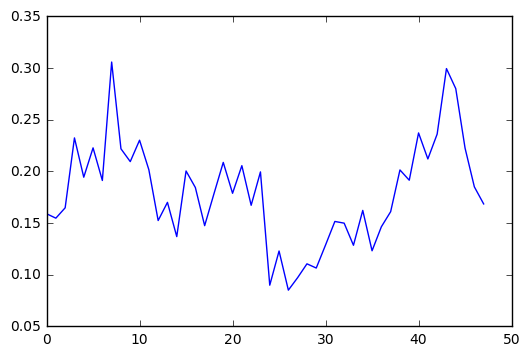

In [1441]:
plt.plot(np.array(nt))
#plt.plot(np.array(PCI))

In [1451]:
newtry2 = pd.merge(newtry, PCI, left_on = 'date', right_index = True, how = 'left')
#newtry2 = newtry.dropna()
newtry2 = newtry2.fillna(0)

In [1452]:
newtry2.head()

,masterid,date,jpid,judgeopinion,pajid,agedec,firstjpid,firstpajid,firstagedec,dissent,opposition,pajiddif,Year,Month,Partisan Conflict,PCI lagged 14,PCI lagged 28,PCI lagged 56,PCI lagged 112
0,95.010009765625,1995-12-01,2.0,2,8.11,0.327267,1.0,47.23,66.0,0,1,-1.391823,1995,12,2.787213,2.346222,2.427347,1.48767,1.594355
1,95.010009765625,1995-12-01,1.0,2,30.69,-0.714848,1.0,47.23,66.0,0,0,-0.584480,1995,12,2.787213,2.346222,2.427347,1.48767,1.594355
2,95.010009765625,1995-12-01,1.0,2,45.44,-0.367477,1.0,47.23,66.0,0,0,-0.057097,1995,12,2.787213,2.346222,2.427347,1.48767,1.594355
3,95.010009765625,1995-12-01,1.0,2,36.28,-1.322749,1.0,47.23,66.0,0,0,-0.384611,1995,12,2.787213,2.346222,2.427347,1.48767,1.594355
4,95.01001739501953,1995-12-01,2.0,2,8.11,0.414110,1.0,26.20,65.0,0,1,-0.639900,1995,12,2.787213,2.346222,2.427347,1.48767,1.594355


In [1453]:
x = newtry2[newtry2['opposition']==1][['Partisan Conflict', 'PCI lagged 28', 'PCI lagged 56', 'PCI lagged 112', 'pajiddif', 'agedec']]
y = newtry2[newtry2['opposition']==1]['dissent']

In [1454]:
x = sm.add_constant(x)
lr = sm.Logit(y, x)
res = lr.fit()
print(res.params)
print(res.bse)

Optimization terminated successfully.
         Current function value: 0.468818
         Iterations 5
const               -1.537207
Partisan Conflict   -0.027360
PCI lagged 28        0.073954
PCI lagged 56        0.041261
PCI lagged 112       0.054636
pajiddif             0.014410
agedec               0.016028
dtype: float64
const                0.008914
Partisan Conflict    0.013680
PCI lagged 28        0.017111
PCI lagged 56        0.013988
PCI lagged 112       0.010071
pajiddif             0.008861
agedec               0.010075
dtype: float64


In [1448]:
x = newtry2[newtry2['opposition']==0][['Partisan Conflict','PCI lagged 28', 'PCI lagged 56', 'pajiddif', 'agedec']]
y = newtry2[newtry2['opposition']==0]['dissent']
x = sm.add_constant(x)
lr = sm.Logit(y, x)
res = lr.fit()
print(res.params)
print(res.bse)

Optimization terminated successfully.
         Current function value: 0.431448
         Iterations 6
const               -1.681559
Partisan Conflict   -0.051917
PCI lagged 28       -0.047773
PCI lagged 56       -0.026755
pajiddif            -0.026894
agedec               0.026889
dtype: float64
const                0.011780
Partisan Conflict    0.018365
PCI lagged 28        0.023545
PCI lagged 56        0.017965
pajiddif             0.018328
agedec               0.013165
dtype: float64


## Lagged outcome

In [1449]:
#PCI['PCI lagged 7'] = PCI['Partisan Conflict'].shift(-7).fillna(method='ffill')
PCI['PCI lagged 14'] = PCI['Partisan Conflict'].shift(-14)#.fillna(method='ffill')
PCI['PCI lagged 28'] = PCI['Partisan Conflict'].shift(-28)#.fillna(method='ffill')
PCI['PCI lagged 56'] = PCI['Partisan Conflict'].shift(-56)#.fillna(method='ffill')
PCI['PCI lagged 112'] = PCI['Partisan Conflict'].shift(-112)

In [1450]:
PCI

,Partisan Conflict,PCI lagged 14,PCI lagged 28,PCI lagged 56,PCI lagged 112
date,,,,,
1995-01-15,0.253971,1.087631,1.288041,0.800431,0.924473
1995-01-16,0.338251,1.119998,1.284770,0.780365,0.946513
1995-01-17,0.419971,1.149217,1.279648,0.761042,0.969119
1995-01-18,0.497339,1.175381,1.253646,0.796143,0.992284
1995-01-19,0.570447,1.198582,1.264223,0.724981,1.016001
1995-01-20,0.639388,1.218914,1.254105,0.708329,1.040264
1995-01-21,0.704255,1.236468,1.242507,0.692593,1.065066
1995-01-22,0.765140,1.251338,1.229522,0.677765,1.090400
1995-01-23,0.822136,1.263615,1.215241,0.663840,1.167868
